Взял свой ноутбук с курса "Обработка и генерация изображений" и модифицировал его

# Подготовка данных и модели

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import cv2
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import numpy as np


normal_images_train = [cv2.imread(os.path.join('./dataset/train', fn)) for fn in tqdm(os.listdir('./dataset/train'))]
images_test = [cv2.imread(os.path.join('./dataset/test/imgs', fn)) for fn in tqdm(os.listdir('./dataset/test/imgs'))]
abnormal_images = [cv2.imread(os.path.join('./dataset/proliv', fn)) for fn in tqdm(os.listdir('./dataset/proliv'))]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

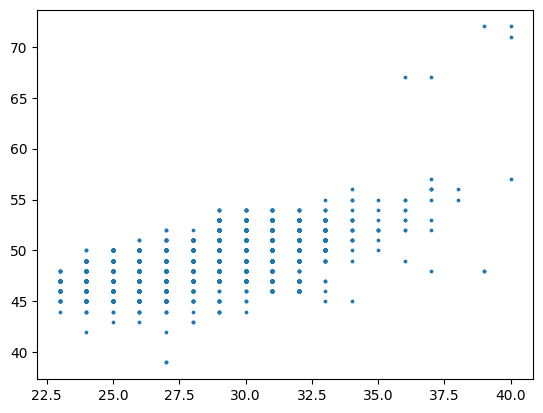

In [2]:
shapes = [i.shape[:2] for i in normal_images_train] + [i.shape[:2] for i in images_test] + [i.shape[:2] for i in abnormal_images]
shapes = np.array(shapes)

plt.scatter(shapes[:, 0], shapes[:, 1], s=3)

In [3]:
def initial_transforms(image):
    image = cv2.resize(image, (60, 60), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = torch.FloatTensor(image / 255).unsqueeze(0)

    return image

normal_images_train = torch.stack(list(map(initial_transforms, normal_images_train)))
images_test = torch.stack(list(map(initial_transforms, images_test)))
abnormal_images = torch.stack(list(map(initial_transforms, abnormal_images)))

In [4]:
class MemoryModule(nn.Module):
    def __init__(self):
        super(MemoryModule, self).__init__()

    def get_score(self, queries, memory):
        return torch.matmul(queries.permute(0, 2, 3, 1), memory.permute(1, 0)) # (B, H, W, C) x (C, M) -> (B, H, W, M)
    
    def __read(self, queries, memory):
        scores = self.get_score(queries, memory)
        scores = F.softmax(scores, dim=-1)

        result = torch.cat([torch.matmul(scores, memory).permute(0, 3, 1, 2), queries], dim=1) # (B, 2C, H, W)

        return result

    def __update(self, queries, memory):        
        qm_distances = self.get_score(queries, memory)
        qm_distances = qm_distances.view(-1, qm_distances.shape[-1])

        # topk for sampling
        _, query_indices = torch.topk(F.softmax(qm_distances, dim=0), k=1, dim=0)

        mem_increment = torch.zeros(memory.shape).to('cuda')

        for m in range(memory.shape[0]):
            # if no queries were selected
            if query_indices[:, m].shape[0] == 0:
                mem_increment[m] = 0

            else:
                # get scores
                scores = qm_distances[query_indices[:, m]] # (S, C)
                # re-normalize
                scores /= scores.max(dim=0)[0]
                # (M, 1) x (1, C), (C, ) after sum
                mem_increment[m] = torch.sum(torch.matmul(scores.permute(1, 0), queries.view(-1, queries.shape[-1])[query_indices[:, m]]), dim=1)

        return F.normalize(memory + mem_increment, dim=0).detach() # gives error otherwise

    def forward(self, queries, memory):
        updated_queries = self.__read(queries, memory)
        memory = self.__update(queries, memory)

        return updated_queries, memory


class ReconstuctionAutoencoder(nn.Module):
    def __init__(self, scale_factor=1):
        super(ReconstuctionAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, int(32*scale_factor), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(int(32*scale_factor), int(64*scale_factor), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(int(64*scale_factor), int(128*scale_factor), 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # nn.Conv2d(int(128*scale_factor), int(256*scale_factor), 3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),

            # nn.Conv2d(int(128*scale_factor), int(256*scale_factor), 3, padding=1),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(int(256*scale_factor), int(256*scale_factor), 2, 2),
            # nn.Conv2d(int(256*scale_factor), int(128*scale_factor), 3, padding=1),
            # nn.ReLU(inplace=True),
            
            # nn.ConvTranspose2d(int(256*scale_factor), int(256*scale_factor), 2, 2),
            # nn.Conv2d(int(256*scale_factor), int(128*scale_factor), 3, padding=2),
            # nn.ReLU(inplace=True),

            nn.ConvTranspose2d(int(128*scale_factor*2), int(128*scale_factor*2), 2, 2),
            nn.Conv2d(int(128*scale_factor*2), int(64*scale_factor*2), 3, padding=1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(int(64*scale_factor*2), int(64*scale_factor*2), 2, 2),
            nn.Conv2d(int(64*scale_factor*2), int(32*scale_factor*2), 3, padding=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(int(32*scale_factor*2), int(32*scale_factor*2), 2, 2),
            nn.Conv2d(int(32*scale_factor*2), 1, 3, padding=1),
            nn.Sigmoid()
        )

        self.memory = MemoryModule()

    def forward(self, x, memory):
        latent_x = self.encoder(x)
        updated_x, memory = self.memory(latent_x, memory)
        reconstructed_x = self.decoder(updated_x)

        return reconstructed_x, memory

# Обучение модели и определение референсных значений ошибки реконструкции

In [5]:
from torchinfo import summary

epochs = 25
batch_size = 256
dsize = (60, 60)
huber_delta = 0.1
memory_size = 128

model = ReconstuctionAutoencoder(scale_factor=1.)

summary(model, input_size=[(batch_size, 1, dsize[1], dsize[0]), (memory_size, 128)], device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
ReconstuctionAutoencoder                 [256, 1, 60, 60]          --
├─Sequential: 1-1                        [256, 128, 7, 7]          --
│    └─Conv2d: 2-1                       [256, 32, 60, 60]         320
│    └─ReLU: 2-2                         [256, 32, 60, 60]         --
│    └─MaxPool2d: 2-3                    [256, 32, 30, 30]         --
│    └─Conv2d: 2-4                       [256, 64, 30, 30]         18,496
│    └─ReLU: 2-5                         [256, 64, 30, 30]         --
│    └─MaxPool2d: 2-6                    [256, 64, 15, 15]         --
│    └─Conv2d: 2-7                       [256, 128, 15, 15]        73,856
│    └─ReLU: 2-8                         [256, 128, 15, 15]        --
│    └─MaxPool2d: 2-9                    [256, 128, 7, 7]          --
├─MemoryModule: 1-2                      [256, 256, 7, 7]          --
├─Sequential: 1-3                        [256, 1, 60, 60]          --
│    └

In [6]:
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T


def add_random_noise(image):
    image += torch.FloatTensor(*image.shape).normal_(0, 0.1).to('cuda')

    return image


def calculate_compactness_loss(model, x, memory):
    queries = model.encoder(x)
    scores = model.memory.get_score(queries, memory)
    scores = F.softmax(scores, dim=-1)
    queries = queries.permute(0, 2, 3, 1)
    
    queries = queries.contiguous().view(-1, queries.shape[-1])
    
    _, indices = torch.topk(scores.view(-1, scores.shape[-1]), k=1, dim=-1)
    
    return F.mse_loss(queries, memory[indices].squeeze(1).detach())


def calculate_separateness_loss(model, x, memory):
    queries = model.encoder(x)
    scores = model.memory.get_score(queries, memory)
    scores = F.softmax(scores, dim=-1)

    queries = queries.permute(0, 2, 3, 1)
    queries = queries.contiguous().view(-1, queries.shape[-1])

    _, indices = torch.topk(scores.view(-1, scores.shape[-1]), k=2, dim=-1)

    positives = memory[indices[:,0]].detach()
    negatives = memory[indices[:,1]].detach()

    return F.triplet_margin_loss(queries, positives, negatives, margin=1.)   


class RMSELoss(object):
    def __init__(self, reduction='mean'):
        self.reduction = reduction

    def __call__(self, x, x_reconstructed):
        return torch.sqrt(nn.functional.mse_loss(x, x_reconstructed, reduction=self.reduction))


train_transforms = T.Compose([T.Normalize(mean=0, std=1),
                              add_random_noise])

train_dataset = TensorDataset(normal_images_train)
abnormal_images_dataset = TensorDataset(abnormal_images)

train_loader = DataLoader(train_dataset, batch_size=batch_size)

# хочу по ходу обучения отследить динамику ошибки для нормальных и аномальных изображений
abnormal_images_loader = DataLoader(abnormal_images_dataset, batch_size=batch_size)

# reconstruction_criterion = nn.HuberLoss(delta=huber_delta)
# reconstruction_criterion_wo_reduction = nn.HuberLoss(delta=huber_delta, reduction='none')

# reconstruction_criterion = RMSELoss()
# reconstruction_criterion_wo_reduction = RMSELoss(reduction='none')

reconstruction_criterion = nn.MSELoss()
reconstruction_criterion_wo_reduction = nn.MSELoss(reduction='none')

optimizer = torch.optim.NAdam(model.parameters())

train_reconstruction_loss_history = list()
train_compactness_loss_history = list()
train_separateness_loss_history = list()

abnormal_reconstruction_loss_history = list()
abnormal_compactness_loss_history = list()
abnormal_separateness_loss_history = list()

model.to('cuda')

memory = F.normalize(torch.rand((memory_size, 128), dtype=torch.float), dim=1).to('cuda') # initialize the memory
for epoch in tqdm(range(epochs)):
    model.train()

    train_reconstruction_loss = 0
    train_compactness_loss = 0
    train_separateness_loss = 0

    for i, (x, ) in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = x.to('cuda')
        x_reconstructed, memory = model(train_transforms(x), memory)
        
        reconstruction_loss = reconstruction_criterion(x_reconstructed, x)
        compactness_loss = calculate_compactness_loss(model, x, memory)
        separateness_loss = calculate_separateness_loss(model, x, memory)

        loss = reconstruction_loss + compactness_loss + separateness_loss
        
        train_reconstruction_loss += reconstruction_loss.item()
        train_compactness_loss += compactness_loss.item()
        train_separateness_loss += separateness_loss.item()

        if epoch % 5 == 0:
            print(f'\rEpoch {epoch}/{epochs}, {i+1}/{len(train_loader)}: loss: {loss.item()/(i+1)}', end='')

        loss.backward()
        optimizer.step()

    train_reconstruction_loss_history.append(train_reconstruction_loss / len(train_loader))
    train_compactness_loss_history.append(train_compactness_loss / len(train_loader))
    train_separateness_loss_history.append(train_separateness_loss / len(train_loader))
    
    model.eval()

    abnormal_reconstruction_loss = 0
    abnormal_compactness_loss = 0
    abnormal_separateness_loss = 0
    for i, (x,) in enumerate(abnormal_images_loader):
        x = x.to('cuda')

        with torch.no_grad():
            x_reconstructed, memory = model(x, memory)
        
            reconstruction_loss = reconstruction_criterion(x_reconstructed, x)
            compactness_loss = calculate_compactness_loss(model, x, memory)
            separateness_loss = calculate_separateness_loss(model, x, memory)

        loss = reconstruction_loss + compactness_loss + separateness_loss
        abnormal_reconstruction_loss += reconstruction_loss.item()
        abnormal_compactness_loss += compactness_loss.item()
        abnormal_separateness_loss += separateness_loss.item()
        
    if epoch % 5 == 0:    
        print(f', abnormal samples loss: {loss.item()/len(abnormal_images_loader)}')
        
    abnormal_reconstruction_loss_history.append(abnormal_reconstruction_loss / len(abnormal_images_loader))
    abnormal_compactness_loss_history.append(abnormal_compactness_loss / len(abnormal_images_loader))
    abnormal_separateness_loss_history.append(abnormal_separateness_loss / len(abnormal_images_loader))

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 0/25, 40/40: loss: 0.025137451291084294, abnormal samples loss: 1.009202003479004
Epoch 5/25, 40/40: loss: 0.025127163529396056, abnormal samples loss: 1.0088149309158325
Epoch 10/25, 40/40: loss: 0.025123009085655214, abnormal samples loss: 1.0084905624389648
Epoch 15/25, 40/40: loss: 0.025122764706611633, abnormal samples loss: 1.0084748268127441
Epoch 20/25, 40/40: loss: 0.025122371315956116, abnormal samples loss: 1.0084648132324219


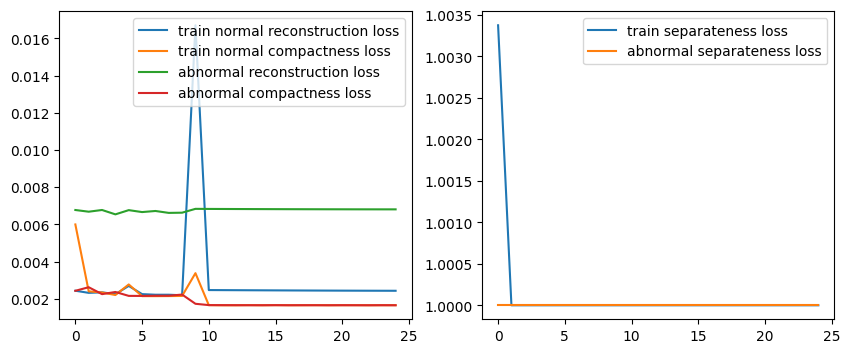

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

axes[0].plot(train_reconstruction_loss_history, label='train normal reconstruction loss')
axes[0].plot(train_compactness_loss_history, label='train normal compactness loss')
axes[0].plot(abnormal_reconstruction_loss_history, label='abnormal reconstruction loss')
axes[0].plot(abnormal_compactness_loss_history, label='abnormal compactness loss')

axes[1].plot(train_separateness_loss_history, label='train separateness loss')
axes[1].plot(abnormal_separateness_loss_history, label='abnormal separateness loss')

axes[0].legend()
axes[1].legend()

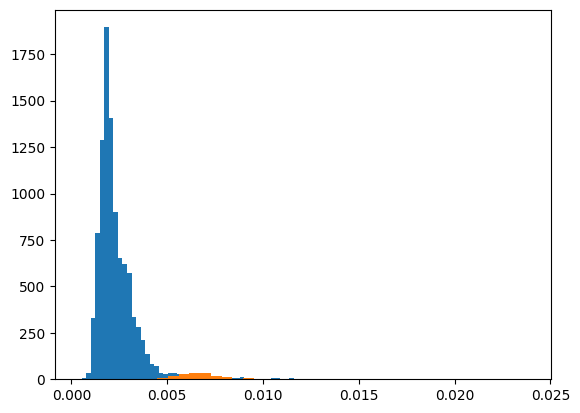

In [8]:
train_reconstructed_images = list()
abnormal_reconstructed_images = list()

train_original_images = list()
abnormal_original_images = list()

with torch.no_grad():
    for i, (x,) in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = x.to('cuda')
        x_reconstructed, memory = model(train_transforms(x), memory)
        
        train_reconstructed_images.append(x_reconstructed.cpu())
        train_original_images.append(x.cpu())

    for i, (x,) in enumerate(abnormal_images_loader):
        x = x.to('cuda')
        x_reconstructed, memory = model(x, memory)

        abnormal_reconstructed_images.append(x_reconstructed.cpu())
        abnormal_original_images.append(x.cpu())

train_reconstructed_images = torch.cat(train_reconstructed_images)
abnormal_reconstructed_images = torch.cat(abnormal_reconstructed_images)

train_original_images = torch.cat(train_original_images)
abnormal_original_images = torch.cat(abnormal_original_images)

train_set_mse = reconstruction_criterion_wo_reduction(train_reconstructed_images, train_original_images).mean(dim=(1, 2, 3)).numpy()
abnormal_set_mse = reconstruction_criterion_wo_reduction(abnormal_reconstructed_images, abnormal_original_images).mean(dim=(1, 2, 3)).numpy()

plt.hist(train_set_mse, bins=100);
plt.hist(abnormal_set_mse, bins=10);

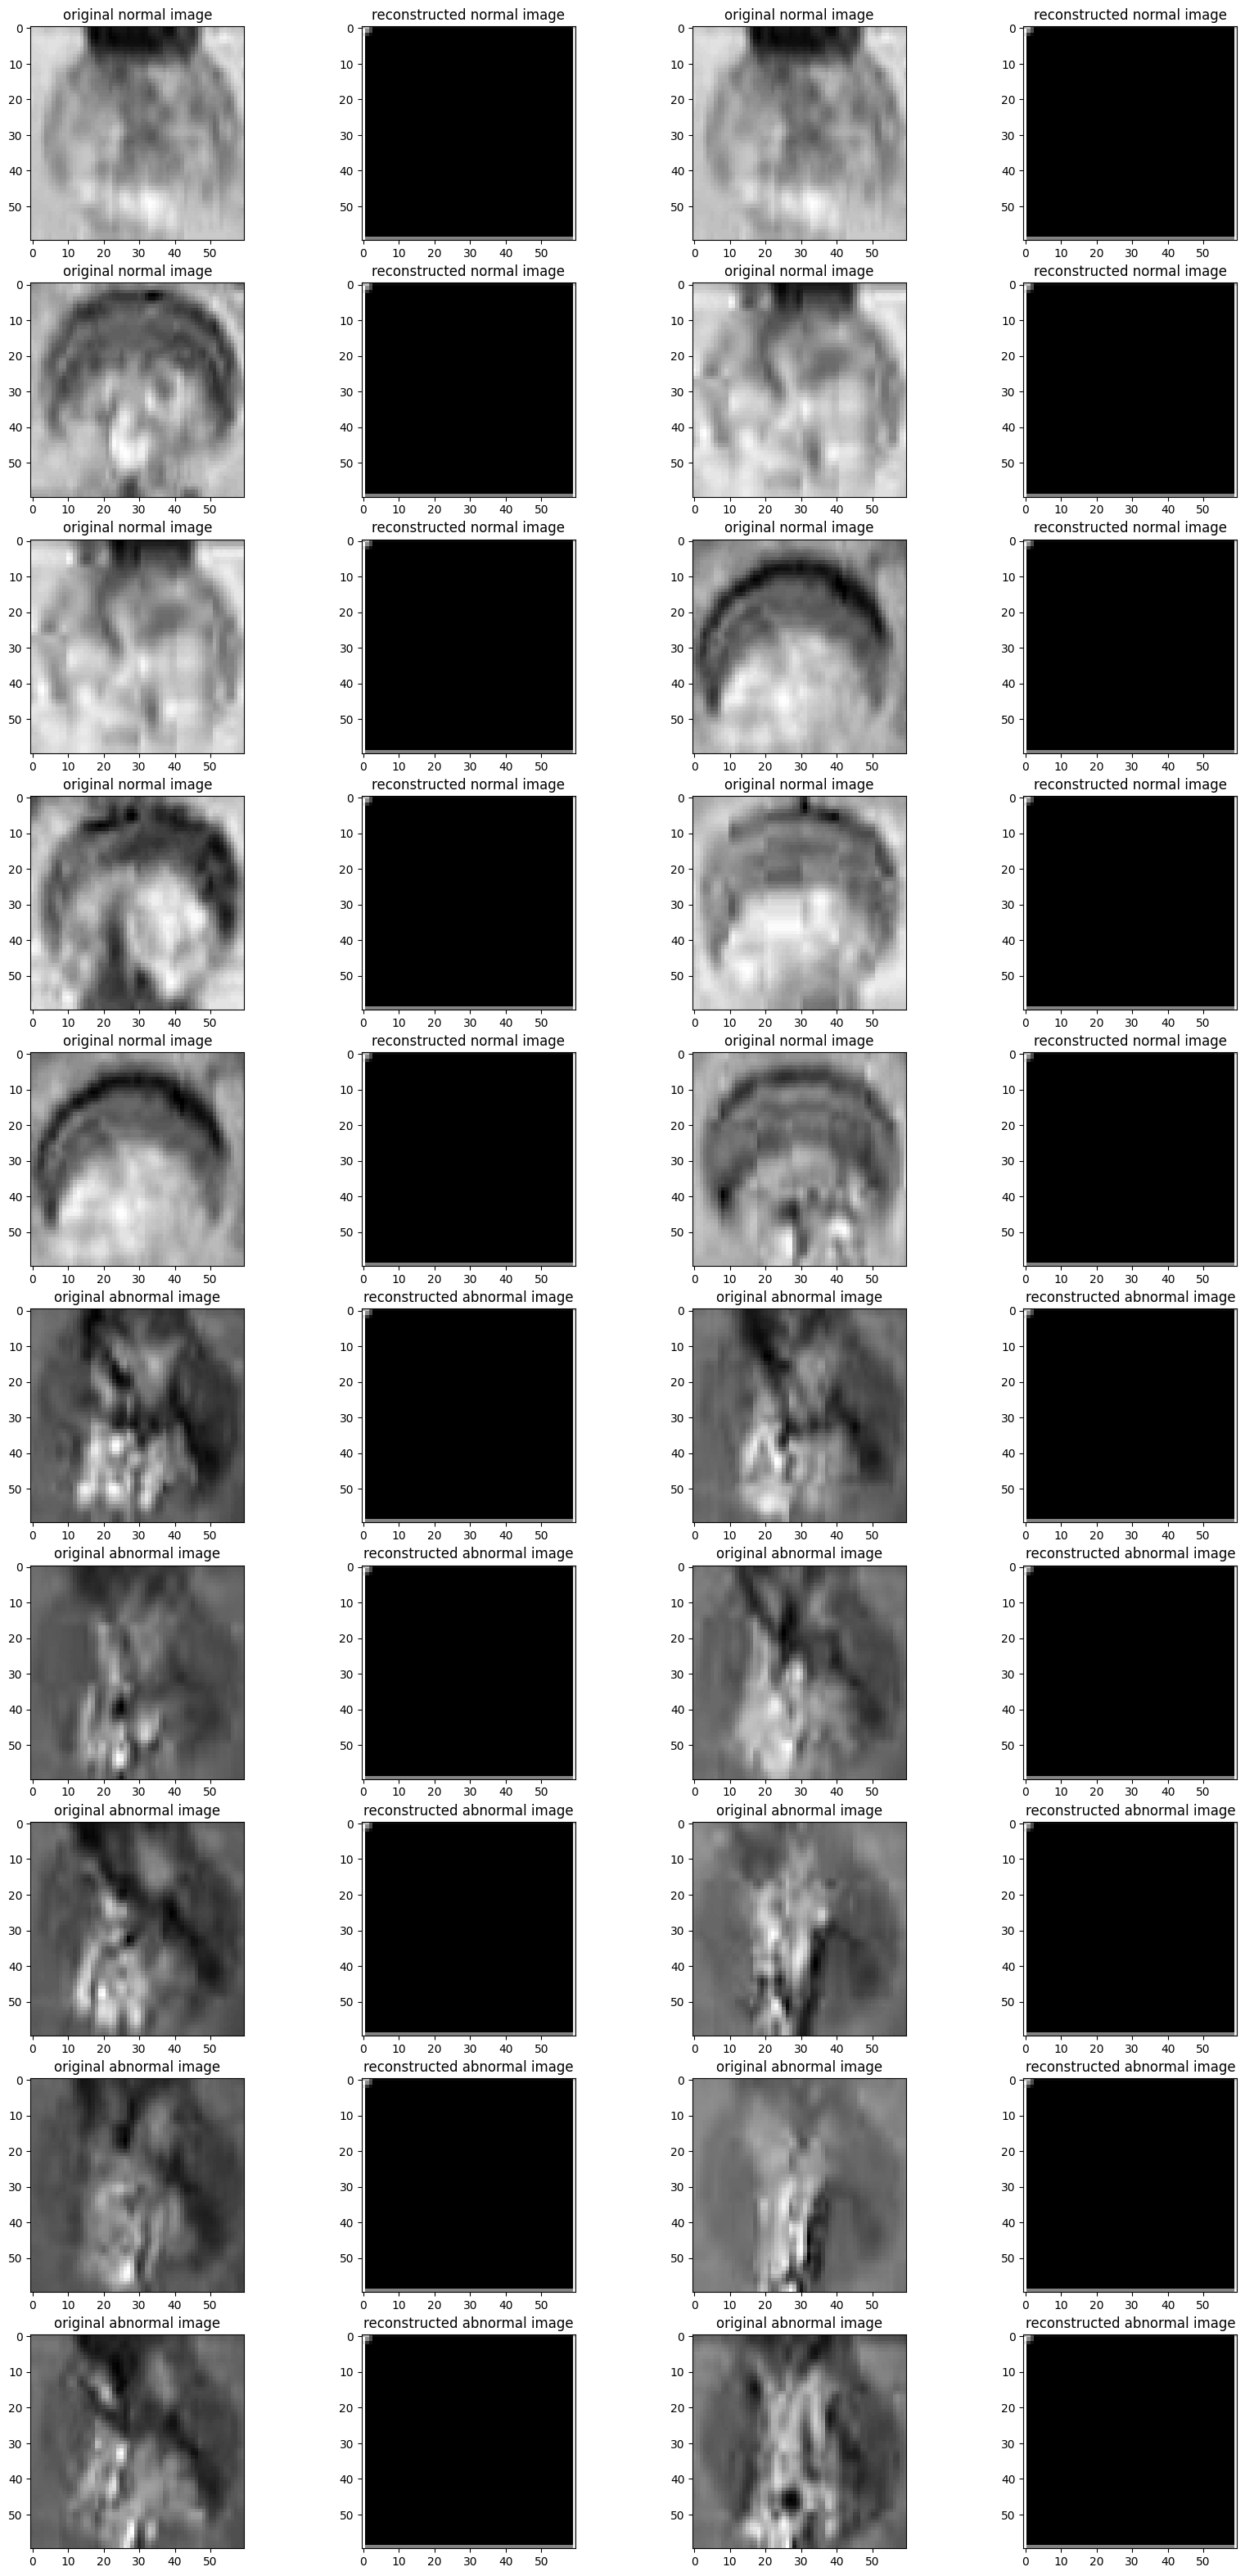

In [9]:
fig, axes = plt.subplots(ncols=4, nrows=10, figsize=(20, 40))

x = next(iter(train_loader))[0]
x_reconstructed, memory = model(x.to('cuda'), memory)

for i in range(5):
    axes[i, 0].imshow(x.detach().cpu().numpy()[i][0], cmap='gray')
    axes[i, 1].imshow(x_reconstructed.detach().cpu().numpy()[i][0], cmap='gray')

    axes[i, 0].set_title('original normal image')
    axes[i, 1].set_title('reconstructed normal image')

    axes[i, 2].imshow(x.detach().cpu().numpy()[i*2][0], cmap='gray')
    axes[i, 3].imshow(x_reconstructed.detach().cpu().numpy()[i*2][0], cmap='gray')

    axes[i, 2].set_title('original normal image')
    axes[i, 3].set_title('reconstructed normal image')

x = next(iter(abnormal_images_loader))[0]
x_reconstructed, memory = model(x.to('cuda'), memory)

for i in range(5, 10):
    axes[i, 0].imshow(x.detach().cpu().numpy()[i][0], cmap='gray')
    axes[i, 1].imshow(x_reconstructed.detach().cpu().numpy()[i][0], cmap='gray')

    axes[i, 0].set_title('original abnormal image')
    axes[i, 1].set_title('reconstructed abnormal image')

    axes[i, 2].imshow(x.detach().cpu().numpy()[i*2][0], cmap='gray')
    axes[i, 3].imshow(x_reconstructed.detach().cpu().numpy()[i*2][0], cmap='gray')

    axes[i, 2].set_title('original abnormal image')
    axes[i, 3].set_title('reconstructed abnormal image')

Внезапно подобное усреднение результатов реконструкции улучшает качество классификации в конце. Мб поправлю потом, но работает и так

In [10]:
def calculate_metrics(original_images, reconstructed_images, labels, err_thr):
    reconstruction_errors = reconstruction_criterion_wo_reduction(reconstructed_images, original_images).mean(dim=(1, 2, 3)).numpy()

    predicted_labels = np.zeros((reconstruction_errors.shape[0], ))
    predicted_labels[reconstruction_errors > err_thr] = 1

    TP = ((predicted_labels + labels) == 2).sum()
    TN = ((predicted_labels + labels) == 0).sum()

    TPR = TP / (labels == 1).sum()
    TNR = TN / (labels == 0).sum()

    return TPR, TNR

TPRs = list()
TNRs = list()

original_images = torch.cat([abnormal_original_images, train_original_images])
reconstructed_images = torch.cat([abnormal_reconstructed_images, train_reconstructed_images])

labels = np.array([1]*abnormal_original_images.shape[0] + [0]*train_original_images.shape[0])
train_val_reconstruction_errors = reconstruction_criterion_wo_reduction(reconstructed_images, original_images).mean(dim=(1, 2, 3)).numpy()

linspace_params = (train_val_reconstruction_errors.min(), train_val_reconstruction_errors.max(), 200)

for thr in np.linspace(*linspace_params):
    TPR, TNR = calculate_metrics(original_images, reconstructed_images, labels, thr)

    TPRs.append(TPR)
    TNRs.append(TNR)

best threshold: 0.005 with TPR=0.968 TNR=0.967


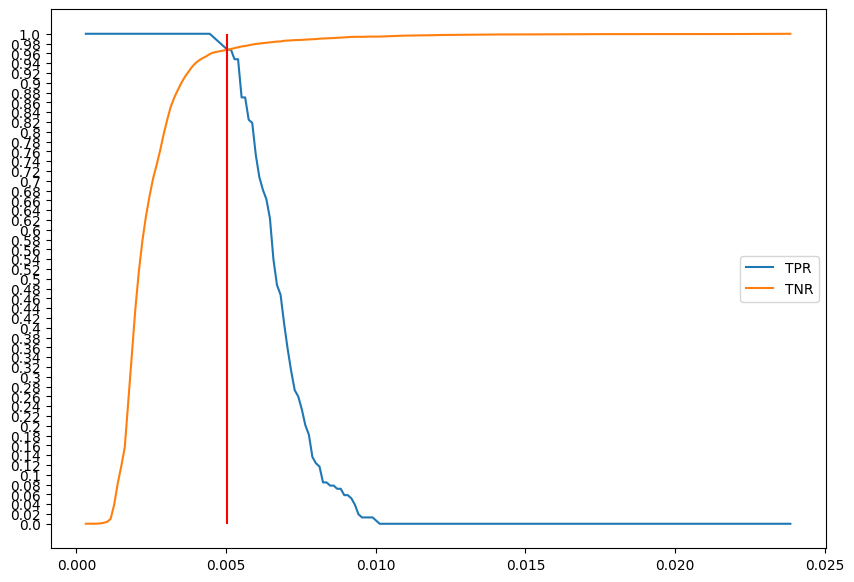

In [11]:
plt.figure(figsize=(10, 7))

plt.plot(np.linspace(*linspace_params), TPRs, label='TPR') 
plt.plot(np.linspace(*linspace_params), TNRs, label='TNR')

best_thr = np.linspace(*linspace_params)[np.argmin(np.abs(np.array(TPRs)-np.array(TNRs)))]
plt.vlines([best_thr], 0, 1, colors=['red'])

plt.yticks(np.round(np.linspace(0, 1, 51), 2), np.round(np.linspace(0, 1, 51), 2))

plt.legend()

TPR, TNR = calculate_metrics(original_images, reconstructed_images, labels, best_thr)
print(f'best threshold: {round(best_thr, 4)} with TPR={round(TPR, 3)} TNR={round(TNR, 3)}')

# Тесты

In [12]:
images_test = {fn: cv2.imread(os.path.join('./dataset/test/imgs', fn)) for fn in tqdm(os.listdir('./dataset/test/imgs'))}
with open('./dataset/test/test_annotation.txt') as f:
    lines = f.readlines()
    lines = [x.strip().split() for x in lines]

    markup = {x[0]: int(x[1]) for x in lines}

images_test = list(dict(sorted(images_test.items(), key=lambda x: x[0])).values())
images_test = torch.stack(list(map(initial_transforms, images_test)))
images_test = T.Normalize(mean=0, std=1)(images_test)

markup = list(dict(sorted(markup.items(), key=lambda x: x[0])).values())

images_test.shape

  0%|          | 0/3794 [00:00<?, ?it/s]

torch.Size([3794, 1, 60, 60])

In [13]:
reconstructed_images = list()

for i in range(images_test.shape[0] // batch_size + (images_test.shape[0] % batch_size != 0)):
    with torch.no_grad():
        reconstructed_x, memory = model(images_test[i*batch_size: (i+1)*batch_size].to('cuda'), memory)
        reconstructed_images.append(reconstructed_x.cpu())

reconstructed_images = torch.cat(reconstructed_images, dim=0)
reconstructed_images.shape

torch.Size([3794, 1, 60, 60])

torch.Size([3794])


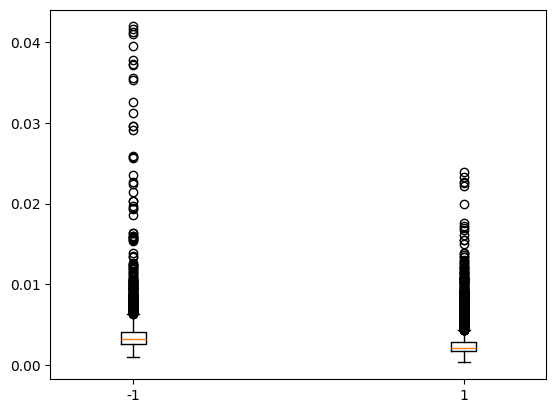

In [14]:
reconstruction_errors = reconstruction_criterion_wo_reduction(reconstructed_images, images_test).mean(dim=(1, 2, 3))
print(reconstruction_errors.shape)

plt.boxplot(reconstruction_errors, positions=[-1])
plt.boxplot(train_val_reconstruction_errors, positions=[1]);

In [15]:
def calculate_metrics(original_images, reconstructed_images, labels, err_thr):
    reconstruction_errors = reconstruction_criterion_wo_reduction(reconstructed_images, original_images).mean(dim=(1, 2, 3)).numpy()

    predicted_labels = np.zeros((reconstruction_errors.shape[0], ))
    predicted_labels[reconstruction_errors > err_thr] = 1

    TP = ((predicted_labels + labels) == 2).sum()
    TN = ((predicted_labels + labels) == 0).sum()

    TPR = TP / (labels == 1).sum()
    TNR = TN / (labels == 0).sum()

    return TPR, TNR

TPRs = list()
TNRs = list()

reconstruction_errors = reconstruction_criterion_wo_reduction(reconstructed_images, images_test).mean(dim=(1, 2, 3)).numpy()
linspace_params = (reconstruction_errors.min(), reconstruction_errors.max(), 200)

for thr in np.linspace(*linspace_params):
    TPR, TNR = calculate_metrics(images_test, reconstructed_images, np.array(markup), thr)

    TPRs.append(TPR)
    TNRs.append(TNR)

train data estimated threshold: 0.005047 with TPR=0.899 TNR=0.846
best threshold: 0.00551 with TPR=0.884 TNR=0.858


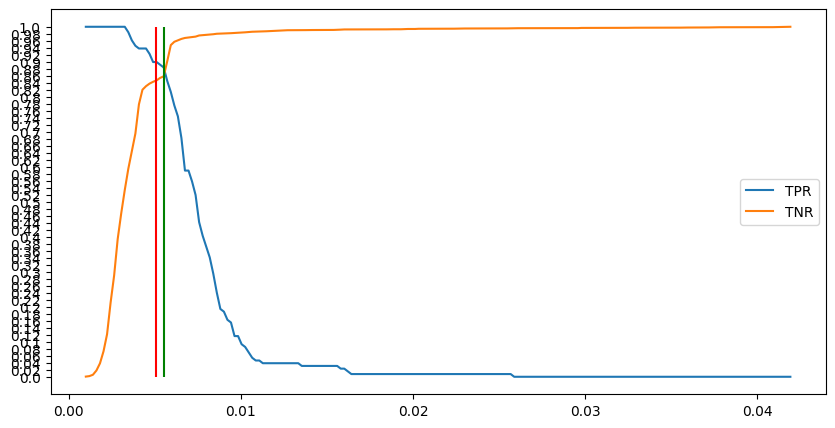

In [16]:
plt.figure(figsize=(10, 5))

plt.plot(np.linspace(*linspace_params), TPRs, label='TPR') 
plt.plot(np.linspace(*linspace_params), TNRs, label='TNR')

best_thr_test = np.linspace(*linspace_params)[np.argmin(np.abs(np.array(TPRs)-np.array(TNRs)))]
plt.vlines([best_thr_test, best_thr], 0, 1, colors=['green', 'red'])

plt.yticks(np.round(np.linspace(0, 1, 51), 2), np.round(np.linspace(0, 1, 51), 2))

plt.legend()

TPR, TNR = calculate_metrics(images_test, reconstructed_images, np.array(markup), best_thr)
print(f'train data estimated threshold: {round(best_thr, 6)} with TPR={round(TPR, 3)} TNR={round(TNR, 3)}')
TPR, TNR = calculate_metrics(images_test, reconstructed_images, np.array(markup), best_thr_test)
print(f'best threshold: {round(best_thr_test, 6)} with TPR={round(TPR, 3)} TNR={round(TNR, 3)}')

Для тестовых данный трешхолд подобрался немного иной, но и подобранный на трейне показывает хорошо

# Визуализация скрытого пространства

Text(0.5, 1.0, 't-SNE')

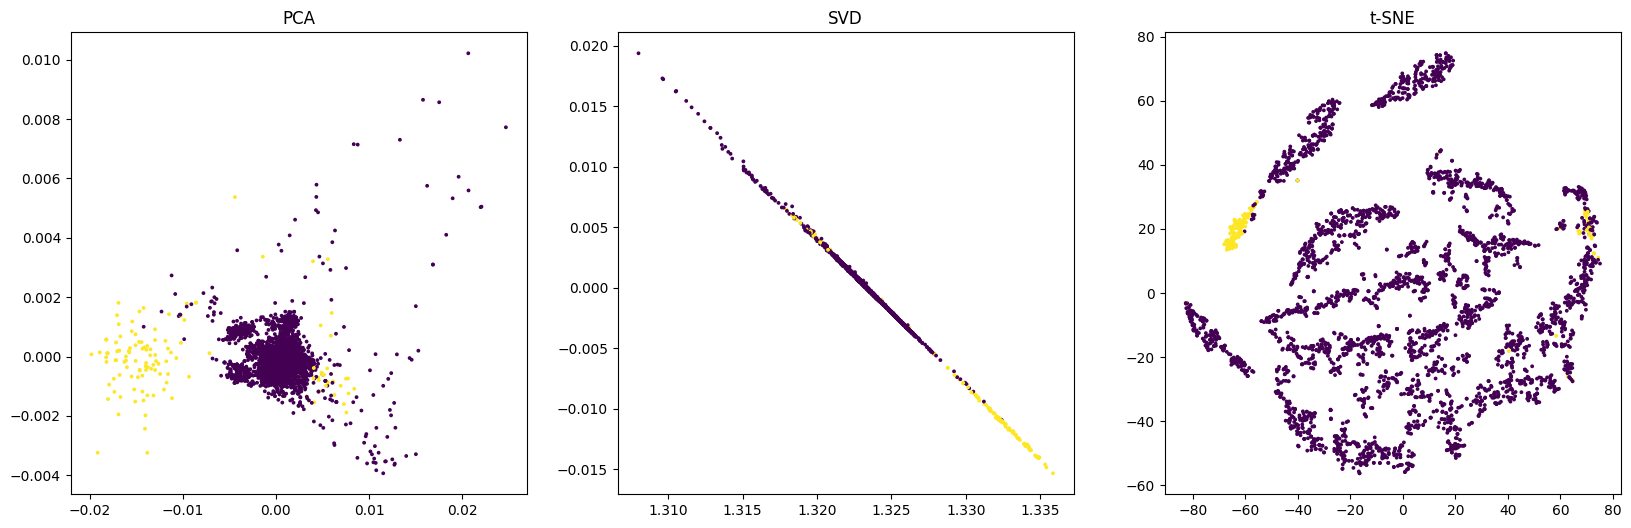

In [17]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE


train_hiddens = list()

for i in range(images_test.shape[0] // batch_size + (images_test.shape[0] % batch_size != 0)):
    with torch.no_grad():
        latent_x = model.encoder(images_test[i*batch_size: (i+1)*batch_size].to('cuda'))
        latent_x, memory = model.memory(latent_x, memory)

    train_hiddens.append(latent_x.cpu())

train_hiddens = torch.cat(train_hiddens, dim=0)
train_hiddens = train_hiddens.mean(dim=(2, 3)).numpy() # мб использовать что-то другое?
# train_hiddens = train_hiddens.permute(0, 2, 3, 1).contiguous().view(-1, train_hiddens.shape[1])

# это работает, я проверил
# markup = torch.IntTensor(markup)
# markup = markup.unsqueeze(1).expand(-1, 49)
# markup = markup.contiguous().view(-1)

pca_decomposed = PCA(n_components=2).fit_transform(train_hiddens)
svd_decomposed = TruncatedSVD(n_components=2).fit_transform(train_hiddens)
tsne_folded = TSNE(n_components=2).fit_transform(train_hiddens)

fig, axes = plt.subplots(ncols=3, figsize=(20, 6))

axes[0].scatter(pca_decomposed[: ,0], pca_decomposed[:, 1], c=markup, s=3)
axes[0].set_title('PCA')
axes[1].scatter(svd_decomposed[: ,0], svd_decomposed[:, 1], c=markup, s=3)
axes[1].set_title('SVD')
axes[2].scatter(tsne_folded[: ,0], tsne_folded[:, 1], c=markup, s=3)
axes[2].set_title('t-SNE')

In [18]:
a = torch.IntTensor([0, 1, 2])

a = a.unsqueeze(1).expand(-1, 2)
a.contiguous().view(-1)

tensor([0, 0, 1, 1, 2, 2], dtype=torch.int32)